# XGBoost model

##  Read cleaned data from pickle 

Preprocessing applied to all files:
- Features with > 90% data missing or > 90% data with the same value were dropped
- If possible, categorical variables with 100s of categories were mapped to coaser categoricals
- Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity
	- https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
- Some "D" columns were normalized for time
- Aggregate features were added using "magic" technique
	- https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works
- Dropped TransactionID and TransactionDT

In [13]:
import pickle
import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
glob.glob('./data/*')

['./data/XGBoost_LR_train_X_2.pkl',
 './data/train_y.pkl',
 './data/XGBoost_train_X_2.pkl',
 './data/XGBoost_test_X_2.pkl',
 './data/readmefirst.md',
 './data/XGBoost_LR_test_X_1.pkl',
 './data/XGBoost_train_X_1.pkl',
 './data/XGBoost_LR_train_X_1.pkl',
 './data/XGBoost_LR_test_X_2.pkl',
 './data/XGBoost_test_X_1.pkl',
 './data/sample_submission.csv']

In [15]:
'''X (version 1)
- Full 200 features
- Dummies created
'''
X_test_1 = pickle.load(open('./data/XGBoost_test_X_1.pkl', 'rb'))
X_train_1 = pickle.load(open('./data/XGBoost_train_X_1.pkl', 'rb'))

'''
X (version 2)
- Removed additional features
    - Highly correlated "C", "D" features
    - Removed features Chris (1st place winners) removed
    - Removed caterogical features withh 200+ categories even after 1)
- Dummies created
'''
X_test_2 = pickle.load(open('./data/XGBoost_test_X_2.pkl', 'rb'))
X_train_2 = pickle.load(open('./data/XGBoost_train_X_2.pkl', 'rb'))

y = pickle.load(open('./data/train_y.pkl', 'rb'))

In [16]:
X_train_1.shape, X_train_2.shape, X_test_1.shape, X_test_2.shape, y.shape

((590540, 1323), (590540, 1303), (506691, 1573), (506691, 1553), (590540,))

In [17]:
# Difference between train and test columns
train_col_1 = set(X_train_1.columns)
test_col_1 = set(X_test_1.columns)

only_train = train_col_1.difference(test_col_1)
only_test = test_col_1.difference(train_col_1)
print("There are", len(only_train), "columns in train but not in test.")
print("There are", len(only_test), "columns in test but not in train.")

# Option 3, keep train as in. Drop "only test" columns from test and add "only train" columns to test
test_nrows = X_test_1.shape[0]
X_test_1= X_test_1.drop(columns=only_test)
X_test_1 = pd.concat([X_test_1, pd.DataFrame(0, index=np.arange(test_nrows), columns=only_train)], axis=1)
print("Final test shape", X_test_1.shape)
print("Final train shape", X_train_1.shape)

There are 360 columns in train but not in test.
There are 610 columns in test but not in train.
Final test shape (506691, 1323)
Final train shape (590540, 1323)


In [18]:
# Difference between train and test columns
train_col_2 = set(X_train_2.columns)
test_col_2 = set(X_test_2.columns)

only_train = train_col_2.difference(test_col_1)
only_test = test_col_2.difference(train_col_1)
print("There are", len(only_train), "columns in train but not in test.")
print("There are", len(only_test), "columns in test but not in train.")

# Option 3, keep train as in. Drop "only test" columns from test and add "only train" columns to test
test_nrows = X_test_2.shape[0]
X_test_2= X_test_2.drop(columns=only_test)
X_test_2 = pd.concat([X_test_2, pd.DataFrame(0, index=np.arange(test_nrows), columns=only_train)], axis=1)
print("Final test shape", X_test_2.shape)
print("Final train shape", X_train_2.shape)

There are 360 columns in train but not in test.
There are 610 columns in test but not in train.
Final test shape (506691, 1303)
Final train shape (590540, 1303)


## Develop a base XGB model

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate,\
KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.externals import joblib 

#### Since xgboost takes a considerable amount of time to run on non-GPU device, the following is a train-test split setup to assist with early stage coding/ debugging.

In [51]:
%%time
seed = 123
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y, test_size = test_size, random_state = seed)

CPU times: user 3.95 s, sys: 489 ms, total: 4.44 s
Wall time: 4.43 s


In [52]:
%%time
base_x1_model = xgb.XGBClassifier(eval_metric='auc', tree_method='gpu_hist', silent = 0,\
                                 objective='binary:logistic', scale_pos_weight = 1)
base_x1_model.fit(X_train, y_train)
print("basic model is fitted")

basic model is fitted
CPU times: user 1min 56s, sys: 39.7 s, total: 2min 36s
Wall time: 2min 32s


In [53]:
%%time
base_x1_y_pred = base_x1_model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, base_x1_y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
base_x1_frp, base_x1_tpr, _ = roc_curve(y_val, base_x1_y_pred)

ROC_AUC score: 95.40%
CPU times: user 7.12 s, sys: 2.3 s, total: 9.42 s
Wall time: 7.31 s


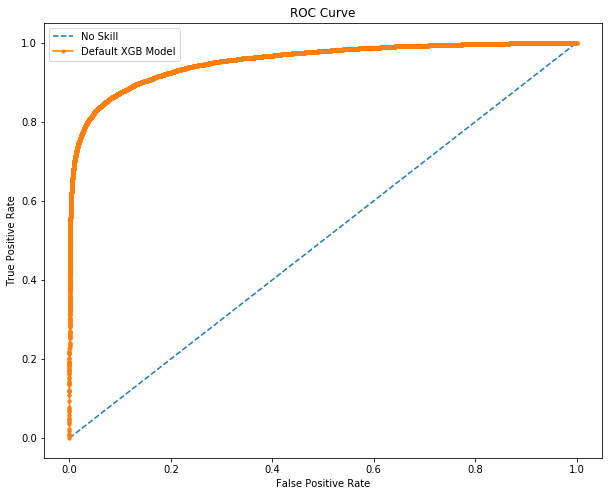

In [24]:
# Define true-positive and false-positive for no skill predictions
no_skill_pred = [0 for _ in range(len(y_val))]
ns_frp, ns_tpr, _ = roc_curve(y_val, no_skill_pred)

# Plot ROC curve across models
plt.figure(figsize=(10, 8))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
plt.plot(base_x1_frp, base_x1_tpr, marker = '.', label='Default XGB Model')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

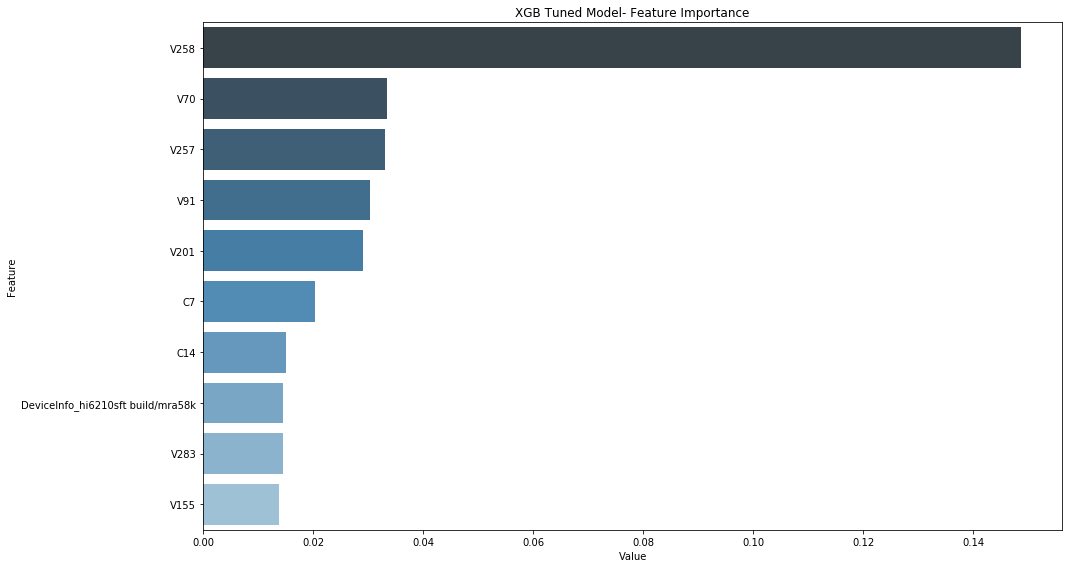

CPU times: user 706 ms, sys: 273 ms, total: 979 ms
Wall time: 430 ms


In [25]:
%%time
# Understand feature importance in the model
feature_imp = pd.DataFrame(sorted(zip(base_x1_model.feature_importances_,X_train_1.columns)), columns=['Value','Feature'])
plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:10],\
            palette = "Blues_d")
plt.title('XGB Tuned Model- Feature Importance')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

### Define Scikit Optimizer function

In [59]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [14]:
# Use train-validation split to tune hyparameters of model
test_size = 0.3
tuning_X_train, tuning_X_val, tuning_y_train, tuning_y_val = train_test_split(X_train,\
                                y_train, test_size = test_size, random_state = seed)
tuning_X = pd.concat([tuning_X_train, tuning_X_val])
tuning_y = pd.concat([tuning_y_train, tuning_y_val])
tuning_train_indices = list(range(tuning_X_train.shape[0]))
tuning_val_indices = list(range(tuning_X_train.shape[0], tuning_X.shape[0]))

In [26]:
# As stated in the documentation, scale_pos_weight allows the model to converge faster.
# Especially when classes are imbalanced
# scale_pos_weight = sqrt(count(negative examples)/count(Positive examples)) 
neg_N = len(y) - sum(y)
pos_N = sum(y)
scale_pos_weight = np.sqrt(neg_N / pos_N)

In [67]:
# number of iterations to scan for 
iterations = 20

# define classifier
estimator = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=0,
        tree_method ='gpu_hist',
        scale_pos_weight = scale_pos_weight
    )

In [46]:
# define hyperparameter space
search_spaces = {
        'n_estimators': Integer(50, 200),
        'learning_rate': Real(0.01, 0.2, 'log-uniform'),
        'max_depth': Integer(3, 15),
        'subsample': Real(0.7, 1.0, 'uniform'),
        'colsample_bytree' : Real(0.3, 0.8, 'uniform'),
        'gamma': [0, 1]
        #'min_child_weight': Real(100, 500),
        #'max_delta_step': Real(0, 20),
        #'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        #'reg_lambda': Real(0.1, 1000, 'log-uniform'),
        #'reg_alpha': Real(0.1, 1.0, 'log-uniform'),
        #'gamma': Real(0.01, 0.5, 'log-uniform')#,
        #'scale_pos_weight': (1e-6, 500, 'log-uniform')
    }

In [47]:
# Set up validation
cv = [(tuning_train_indices, tuning_val_indices)]

In [48]:
xgb_tuner = BayesSearchCV(estimator = estimator, search_spaces = search_spaces, scoring = 'roc_auc',\
                          cv = cv, n_jobs = 3, n_iter = iterations, verbose = 0, refit = True, random_state = seed)

In [49]:
def status_print(optim_result):    
    all_models = pd.DataFrame(xgb_tuner.cv_results_)    
    
    # Get best parameters    
    best_params = pd.Series(xgb_tuner.best_params_)
    print(f'Iteration {len(all_models)}:\nBest ROC-AUC:\
    {np.round(xgb_tuner.best_score_, 4)}\nBestparams:{xgb_tuner.best_params_}\n')
    
    # Save to csv
    clf_name = xgb_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [52]:
result = xgb_tuner.fit(tuning_X.values, tuning_y.values, callback = status_print)

Iteration 1:
Best ROC-AUC:    0.8974
Bestparams:OrderedDict([('colsample_bytree', 0.7293468848796315), ('gamma', 1), ('learning_rate', 0.012995726300576523), ('max_depth', 9), ('n_estimators', 144), ('subsample', 0.7401590061482064)])

Iteration 2:
Best ROC-AUC:    0.9053
Bestparams:OrderedDict([('colsample_bytree', 0.7962590536997258), ('gamma', 5), ('learning_rate', 0.12252835350741892), ('max_depth', 3), ('n_estimators', 124), ('subsample', 0.7546448846552505)])

Iteration 3:
Best ROC-AUC:    0.9053
Bestparams:OrderedDict([('colsample_bytree', 0.7962590536997258), ('gamma', 5), ('learning_rate', 0.12252835350741892), ('max_depth', 3), ('n_estimators', 124), ('subsample', 0.7546448846552505)])

Iteration 4:
Best ROC-AUC:    0.9521
Bestparams:OrderedDict([('colsample_bytree', 0.5813074589686378), ('gamma', 1), ('learning_rate', 0.034863451709054784), ('max_depth', 11), ('n_estimators', 140), ('subsample', 0.8088126682699481)])

Iteration 5:
Best ROC-AUC:    0.9521
Bestparams:OrderedDi

KeyboardInterrupt: 

## Train models  with tuned hyper parameters

From BayesSearch, we find the best ROC-AUC to be:    **0.9726** (hold-out validation set within training set)

Bestparams:
- 'colsample_bytree': 0.8
- 'gamma': 0
- 'learning_rate': 0.1260482919019545
- 'max_depth': 12
- 'n_estimators': 200
- 'subsample': 1.0

In [20]:
params = {
    'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1260482919019545,\
    'max_depth': 12,'n_estimators': 200, 'subsample': 1.0
}

In [28]:
# Fit model with feature set X1
%%time
X1_train, X1_val, y_train, y_val = train_test_split(X_train_1, y, test_size = test_size, random_state = seed)

tuned_x1_model = xgb.XGBClassifier(eval_metric='auc', tree_method='gpu_hist', silent = 0,\
                                 objective='binary:logistic', scale_pos_weight = scale_pos_weight)
tuned_x1_model.set_params(**params)
tuned_x1_model.fit(X1_train, y_train)
print("tuned model is fitted")

tuned model is fitted
CPU times: user 5min 40s, sys: 1min 50s, total: 7min 31s
Wall time: 7min 28s


In [29]:
%%time
tuned_x1_pred = tuned_x1_model.predict_proba(X1_val)[:, 1]
auc_score = roc_auc_score(y_val, tuned_x1_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
tuned_x1_frp, tuned_x1_tpr, _ = roc_curve(y_val, tuned_x1_pred)

ROC_AUC score: 97.47%
CPU times: user 16 s, sys: 2.25 s, total: 18.2 s
Wall time: 9.49 s


In [32]:
%%time
# Fit model with feature set X2
X2_train, X2_val, y_train, y_val = train_test_split(X_train_2, y, test_size = test_size, random_state = seed)
tuned_x2_model = xgb.XGBClassifier(eval_metric='auc', tree_method='gpu_hist', silent = 0,\
                                 objective='binary:logistic', scale_pos_weight = scale_pos_weight)
tuned_x2_model.set_params(**params)
tuned_x2_model.fit(X2_train, y_train)
print("tuned model is fitted")

tuned model is fitted
CPU times: user 5min 31s, sys: 1min 48s, total: 7min 19s
Wall time: 7min 15s


In [33]:
%%time
tuned_x2_pred = tuned_x2_model.predict_proba(X2_val)[:, 1]
auc_score = roc_auc_score(y_val, tuned_x2_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
tuned_x2_frp, tuned_x2_tpr, _ = roc_curve(y_val, tuned_x2_pred)

ROC_AUC score: 97.39%
CPU times: user 15 s, sys: 2.21 s, total: 17.2 s
Wall time: 9.19 s


## Predict fraud probabilities on test set and export to csv for Kaggle submission

Since tuned XGBoost model feature set X1 outperforms feature set X2, we will use XGBoost model trained on set 1 to predict on text set.

In [42]:
set(X_train_1.columns) == set(X_test_1.columns)

True

In [45]:
X_test_aligned = X_test_1[X_train_1.columns]
test_pred = tuned_x1_model.predict_proba(X_test_aligned)[:,1]

In [54]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['isFraud'] = test_pred
sample_submission.to_csv('xgb_test_predictions.csv', index = False)

## Understanding the models

In [48]:
feature_imp_x1 = pd.DataFrame(zip(tuned_x1_model.feature_importances_,X_train_1.columns), columns=['Value','Feature'])
feature_imp_x1 = feature_imp_x1.sort_values('Value', ascending = False).reset_index(drop = True)
feature_imp_x1.head(10)

,Value,Feature
0,0.117279,V258
1,0.034628,DeviceInfo_hi6210sft build/mra58k
2,0.033791,V326
3,0.024371,V70
4,0.019104,ProductCD_W
5,0.018851,V257
6,0.017821,C7
7,0.017703,V201
8,0.016052,V283
9,0.015463,V91


In [49]:
feature_imp_x2 = pd.DataFrame(zip(tuned_x2_model.feature_importances_,X_train_2.columns), columns=['Value','Feature'])
feature_imp_x2 = feature_imp_x2.sort_values('Value', ascending = False).reset_index(drop = True)
feature_imp_x2.head(10)

,Value,Feature
0,0.112938,V258
1,0.036782,V201
2,0.033067,addr2
3,0.029199,DeviceInfo_hi6210sft build/mra58k
4,0.026023,V91
5,0.023387,V70
6,0.023297,ProductCD_W
7,0.017257,V257
8,0.016975,V283
9,0.013765,id_12_NotFound


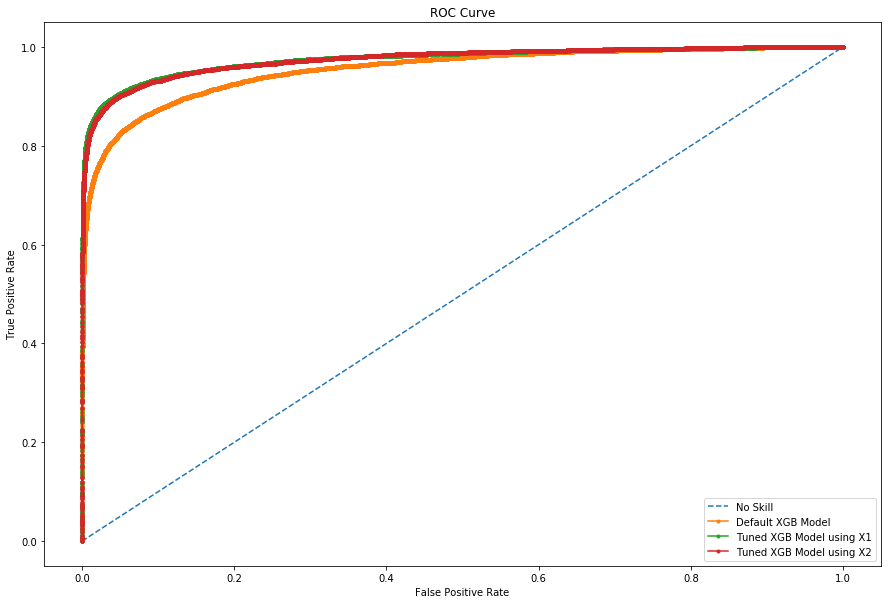

In [55]:
# Plot ROC curve across models

# Define true-positive and false-positive for no skill predictions
no_skill_pred = [0 for _ in range(len(y_val))]
ns_frp, ns_tpr, _ = roc_curve(y_val, no_skill_pred)

plt.figure(figsize=(15, 10))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
# Update
plt.plot(base_x1_frp, base_x1_tpr, marker = '.', label='Default XGB Model')
plt.plot(tuned_x1_frp, tuned_x1_tpr, marker = '.', label='Tuned XGB Model using X1')
plt.plot(tuned_x2_frp, tuned_x2_tpr, marker = '.', label='Tuned XGB Model using X2')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

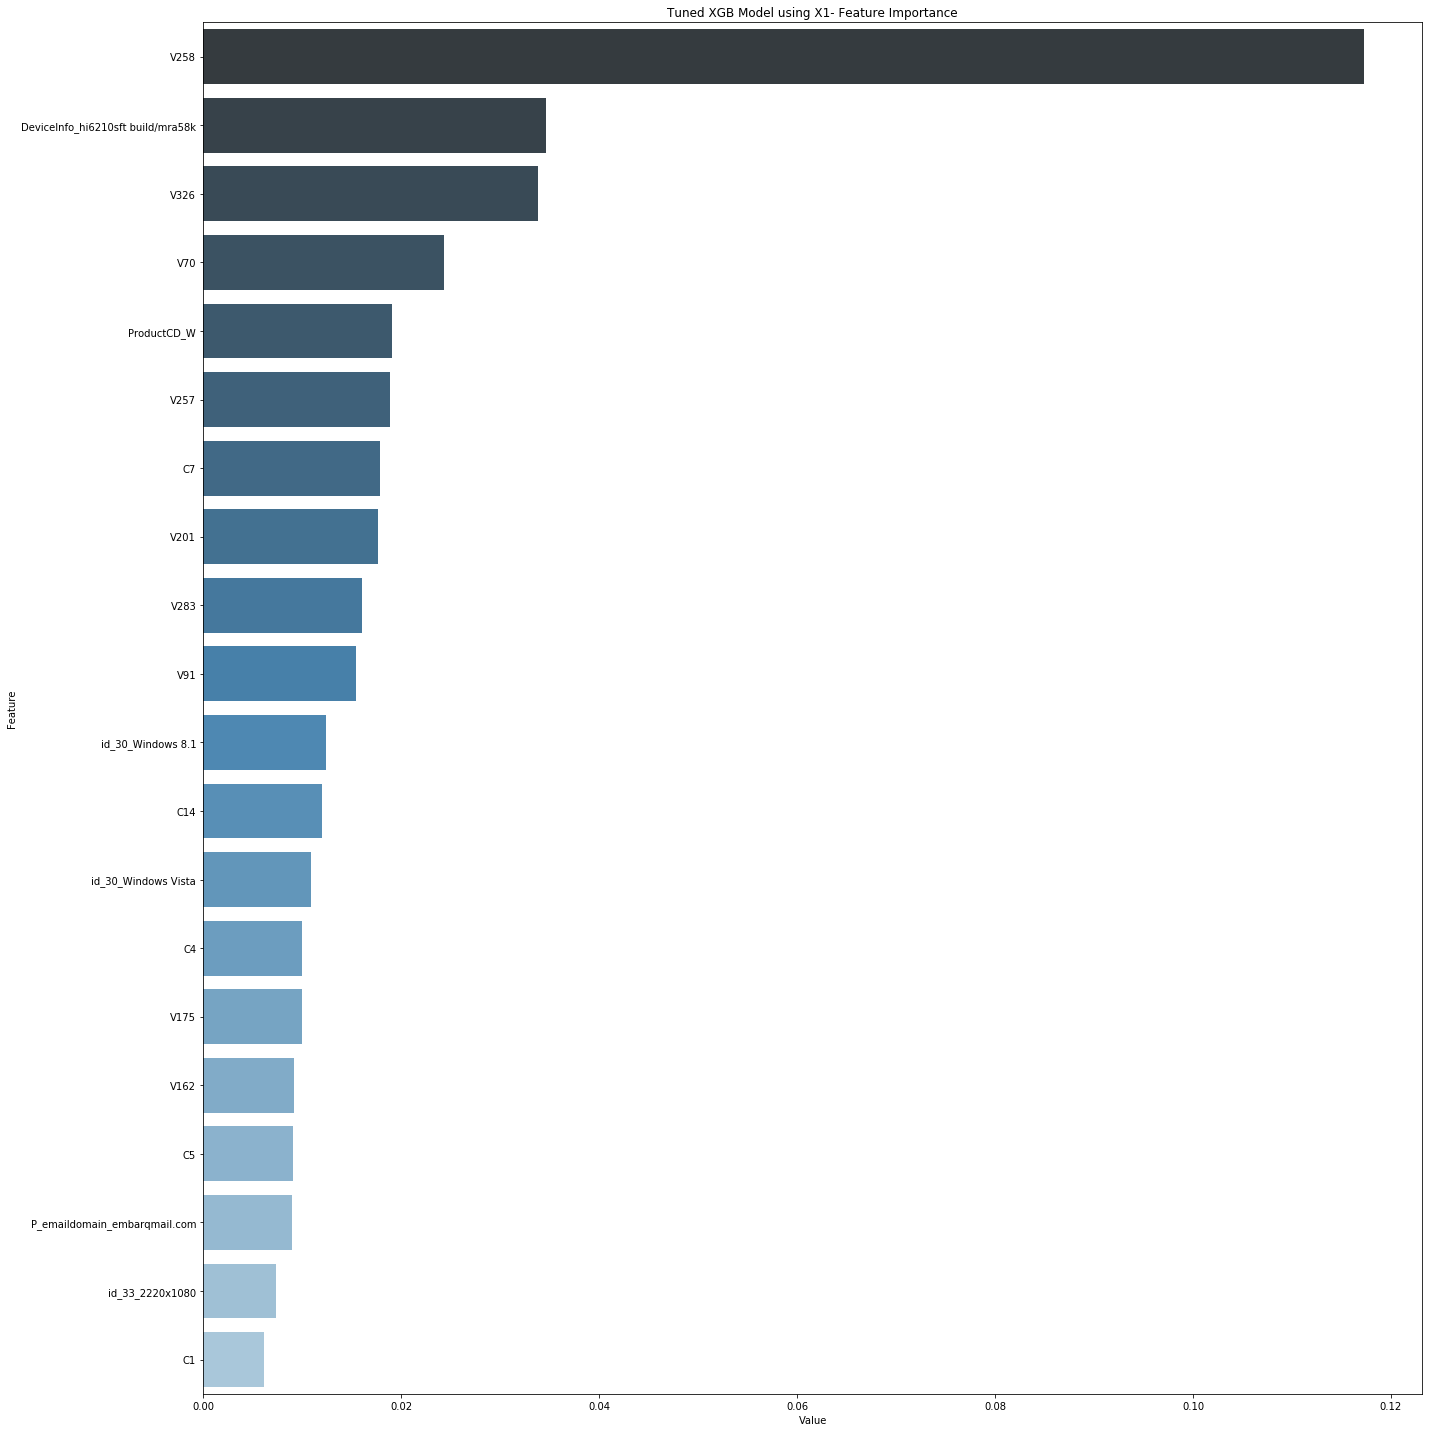

CPU times: user 819 ms, sys: 324 ms, total: 1.14 s
Wall time: 563 ms


In [58]:
%%time
# Understand feature importance in the best model
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp_x1.sort_values(by="Value", ascending=False).iloc[:20],\
            palette = "Blues_d")
plt.title('Tuned XGB Model using X1- Feature Importance')
plt.tight_layout()
plt.show()

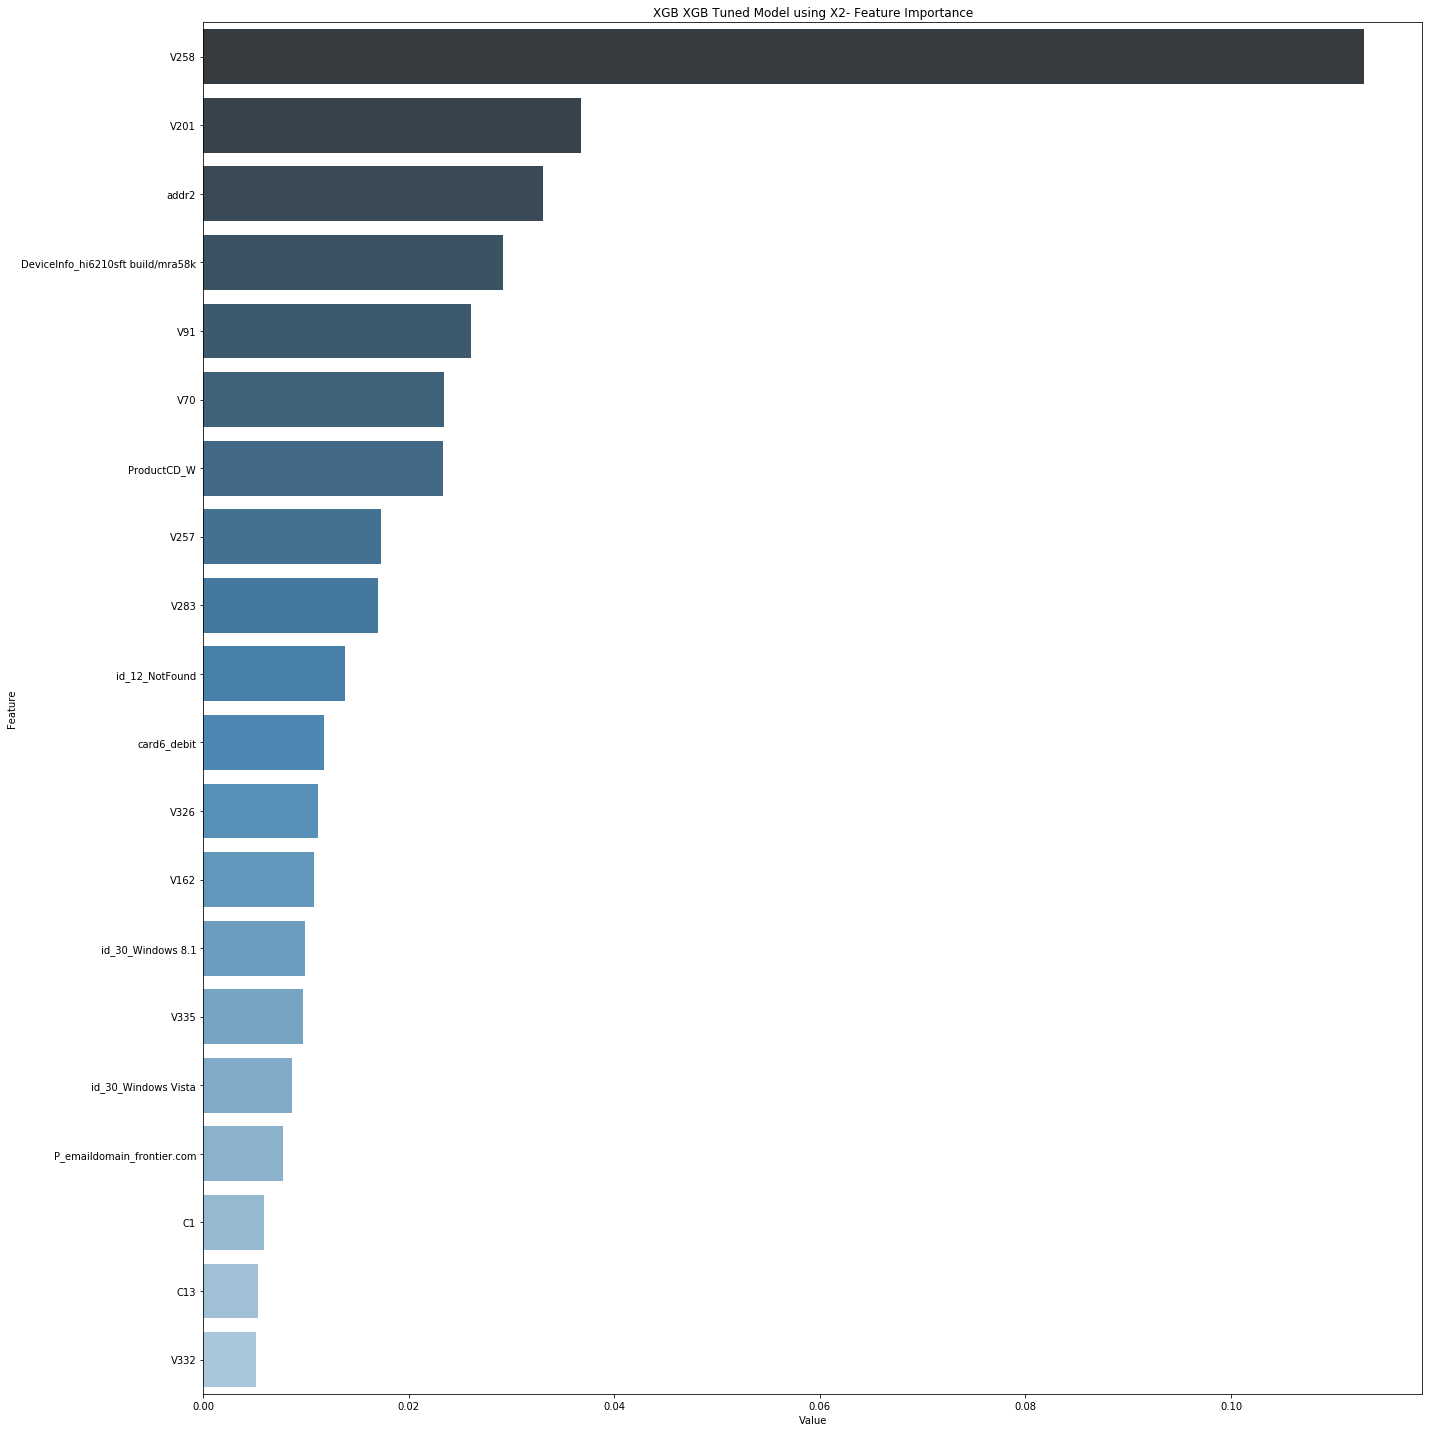

CPU times: user 928 ms, sys: 213 ms, total: 1.14 s
Wall time: 562 ms


In [59]:
%%time
# Understand feature importance in the best model
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp_x2.sort_values(by="Value", ascending=False).iloc[:20],\
            palette = "Blues_d")
plt.title('XGB XGB Tuned Model using X2- Feature Importance')
plt.tight_layout()
plt.show()

## Save Deliverables
We will save the following deliverables:

- Model [pkl format]
- Predicted Probability of validation data (B) [dataframe format]
- Feature Importance [dataframe format]
- ROC curve [png]
- Feature Importance [png]

In [63]:
# Save data for plots and model comparison
# 1) Model
joblib.dump(tuned_x1_model, './results/XGB_X1.pkl') 
joblib.dump(tuned_x2_model, './results/XGB_X2.pkl') 

# 2) Feature Importance
feature_imp_x1.to_pickle("./results/XGB_X1_feature_importance.pkl")
feature_imp_x2.to_pickle("./results/XGB_X2_feature_importance.pkl")

# 3) Val Predictions
validation_results_x1 = pd.DataFrame(zip(y_val, tuned_x1_pred), columns=['True Label','Predicted Label'])
validation_results_x1.to_pickle("./results/XGB_X1_validation_results.pkl")
validation_results_x2 = pd.DataFrame(zip(y_val, tuned_x2_pred), columns=['True Label','Predicted Label'])
validation_results_x2.to_pickle("./results/XGB_X2_validation_results.pkl")